Sertac İnce 

20050111003

In [1]:
import torch
import torch.nn as nn;
import torchvision
import torch.optim as optim

In [2]:
device = torch.device('cuda')

In [3]:
train_data = torchvision.datasets.MNIST(root='./data', 
                       train=True, 
                       transform=torchvision.transforms.transforms.ToTensor(), 
                       download=True)
test_data = torchvision.datasets.MNIST(root='./data', 
                      train=False, 
                      transform=torchvision.transforms.transforms.ToTensor())

In [4]:
# Split proportion for the validation
val_s = int(0.2 *  len(train_data))
train_s = len(train_data) - val_s

In [5]:
train_data , val_data =  torch.utils.data.random_split(train_data, [train_s, val_s])

In [35]:
# Train Function
def train(epochs, model):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # Lists for the accuracy and loss
    loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    
    # Training part
    for epoch in range(epochs):
        lossRun = 0
        correct = 0
        total = 0
        
        for data, target in train_data:
            target = torch.tensor(target).reshape(1)
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad() # zero the gradients
            output = model(data) # forward pass
            loss = criterion(output, target) # calculate loss
            loss.backward() # backward pass
            optimizer.step() # update weights
            lossRun += loss.item()

            # Compute the training accuracy
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

        # Calculating the training accuracy for this epoch
        train_acc = correct / total
        train_acc_list.append(train_acc)
            
        # Calculating the training loss for this epoch
        lossValue = lossRun/len(train_data)
        loss_list.append(lossValue)
        

        # Calculating validation accuracy and loss
        valid_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in val_data:
                target = torch.tensor(target).reshape(1)
                data, target = data.to(device), target.to(device)

                outputs = model(data)
                loss = criterion(outputs, target)
                valid_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

            # Validation accuracy
            valid_acc = correct / total
            val_acc_list.append(valid_acc)    
            # Validation loss
            valid_loss /= len(val_data)
            val_loss_list.append(valid_loss)

        # Print values at the end of the each epoch
        print("Epoch %d - loss: %.4f - accuracy: %.4f - val_loss: %.4f - val_accuracy: %.4f" % (epoch+1, loss_list[-1], train_acc_list[-1], val_loss_list[-1], val_acc_list[-1]))
    
    # Returning the lists
    return loss_list, train_acc_list, val_loss_list, val_acc_list



In [26]:
# Test Function
def test(model, corr=0, corr_val=0, tot=0, tot_val=0):
    criterion = nn.CrossEntropyLoss()
    test_loss = 0.0

    with torch.no_grad():
        for data, target in test_data:
            target = torch.tensor(target).reshape(1)
            data, target = data.to(device), target.to(device)

            output = model(data)
            _, predicted = torch.max(output.data, 1)
            corr += (predicted == target).sum().item()
            tot += target.unsqueeze(0).size(0) 
            
            # Loss calculation
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)

    # Accuracy calculation
    testAcc = round(100 * corr / tot, 2)
    test_loss /= len(test_data)

    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: %{testAcc}")
    


## Model with no hidden layer

In [8]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.softmax(x)
        return x

In [9]:
# Create an instance of the model
model_no_hidden = Net1().to(device=device)
# Print model summary
print(model_no_hidden)

Net1(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


In [10]:
# Train the model
losses, train_accs, val_losses, val_accs = train(10, model_no_hidden)

Epoch 1 - Training Accuracy: 85.681 - Validation Loss: 1.591
Epoch 2 - Training Accuracy: 90.417 - Validation Loss: 1.575
Epoch 3 - Training Accuracy: 91.148 - Validation Loss: 1.568
Epoch 4 - Training Accuracy: 91.494 - Validation Loss: 1.564
Epoch 5 - Training Accuracy: 91.783 - Validation Loss: 1.561
Epoch 6 - Training Accuracy: 91.952 - Validation Loss: 1.558
Epoch 7 - Training Accuracy: 92.098 - Validation Loss: 1.557
Epoch 8 - Training Accuracy: 92.256 - Validation Loss: 1.555
Epoch 9 - Training Accuracy: 92.388 - Validation Loss: 1.554
Epoch 10 - Training Accuracy: 92.496 - Validation Loss: 1.553


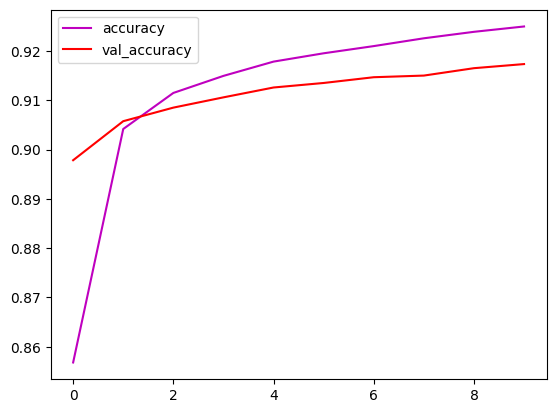

In [22]:
# Plot graphs
import matplotlib.pyplot as plt

plt.plot(range(10), train_accs, color='m', label='accuracy')
plt.plot(range(10),val_accs, color='r', label='val_accuracy')
    
plt.legend()
plt.show()

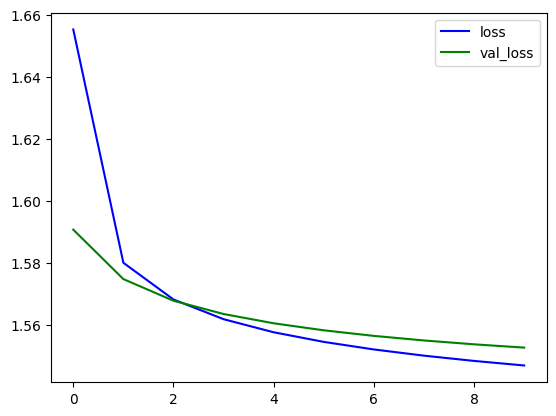

In [21]:
plt.plot(range(10), losses, color='b', label='loss')
plt.plot(range(10), val_losses, color='g', label='val_loss')

plt.legend()
plt.show()

In [27]:
# Print test loss and accuracy
test(model_no_hidden)

Test Loss: 1.5456342685222626
Test Accuracy: %92.52


## Model with single hidden layer

In [28]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 16)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(16, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.sigmoid(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [29]:
# Create an instance of the model
model_one_hidden = Net2().to(device=device)
# Print model summary
print(model_one_hidden)

Net2(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=16, bias=True)
  (sigmoid): Sigmoid()
  (fc2): Linear(in_features=16, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


In [30]:
# Train the model
losses2, train_accs2, val_losses2, val_accs2 = train(20, model_one_hidden)

Epoch 1 - Training Accuracy: 45.225 - Validation Loss: 1.869
Epoch 2 - Training Accuracy: 70.817 - Validation Loss: 1.724
Epoch 3 - Training Accuracy: 79.219 - Validation Loss: 1.663
Epoch 4 - Training Accuracy: 86.077 - Validation Loss: 1.591
Epoch 5 - Training Accuracy: 91.285 - Validation Loss: 1.570
Epoch 6 - Training Accuracy: 92.017 - Validation Loss: 1.561
Epoch 7 - Training Accuracy: 92.542 - Validation Loss: 1.555
Epoch 8 - Training Accuracy: 92.981 - Validation Loss: 1.550
Epoch 9 - Training Accuracy: 93.281 - Validation Loss: 1.547
Epoch 10 - Training Accuracy: 93.548 - Validation Loss: 1.544
Epoch 11 - Training Accuracy: 93.810 - Validation Loss: 1.542
Epoch 12 - Training Accuracy: 94.033 - Validation Loss: 1.540
Epoch 13 - Training Accuracy: 94.227 - Validation Loss: 1.539
Epoch 14 - Training Accuracy: 94.402 - Validation Loss: 1.537
Epoch 15 - Training Accuracy: 94.546 - Validation Loss: 1.536
Epoch 16 - Training Accuracy: 94.690 - Validation Loss: 1.535
Epoch 17 - Traini

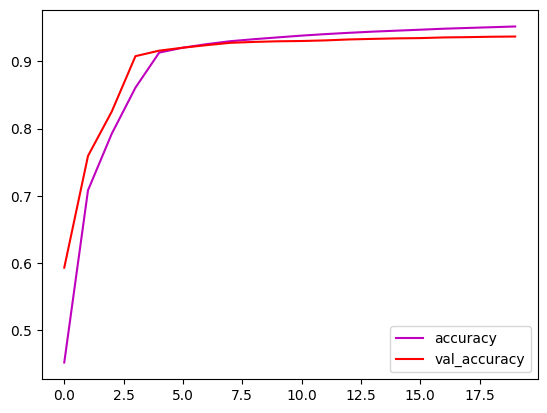

In [32]:
# Plot graphs
plt.plot(range(20), train_accs2, color='m', label='accuracy')
plt.plot(range(20),val_accs2, color='r', label='val_accuracy')
    
plt.legend()
plt.show()

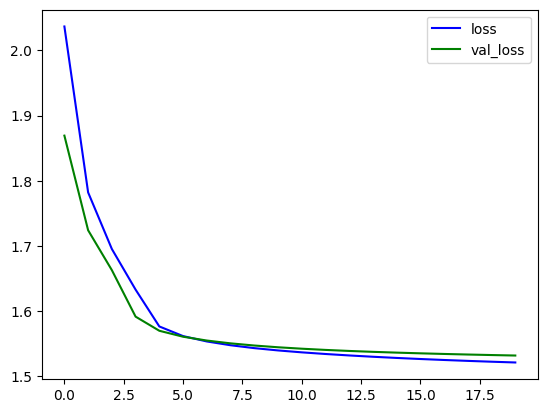

In [33]:
plt.plot(range(20), losses2, color='b', label='loss')
plt.plot(range(20), val_losses2, color='g', label='val_loss')

plt.legend()
plt.show()

In [34]:
# Print test loss and accuracy
test(model_one_hidden)

Test Loss: 1.5294020835757256
Test Accuracy: %93.8


## Deep Model

In [46]:
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 96)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(96, 64)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(64, 32)
        self.relu5 = nn.ReLU()
        self.fc6 = nn.Linear(32, 16)
        self.relu6 = nn.ReLU()
        self.fc7 = nn.Linear(16, 10)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        x = self.relu4(x)
        x = self.fc5(x)
        x = self.relu5(x)
        x = self.fc6(x)
        x = self.relu6(x)
        x = self.fc7(x)
        
        return x

In [47]:
# Create an instance of the model
model_deep = Net3().to(device=device)
# Print model summary
print(model_deep)

Net3(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=96, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=96, out_features=64, bias=True)
  (relu4): ReLU()
  (fc5): Linear(in_features=64, out_features=32, bias=True)
  (relu5): ReLU()
  (fc6): Linear(in_features=32, out_features=16, bias=True)
  (relu6): ReLU()
  (fc7): Linear(in_features=16, out_features=10, bias=True)
)


#### !!! After the homework was finished, the output part disappeared because I accidentally pressed the run button for the cell below. This is the reason why epoch, accuracy, etc. values do not appear under the cell. You can read the values from the graphs below.

In [ ]:
# Train the model
losses3, train_accs3, val_losses3, val_accs3 = train(20, model_deep)

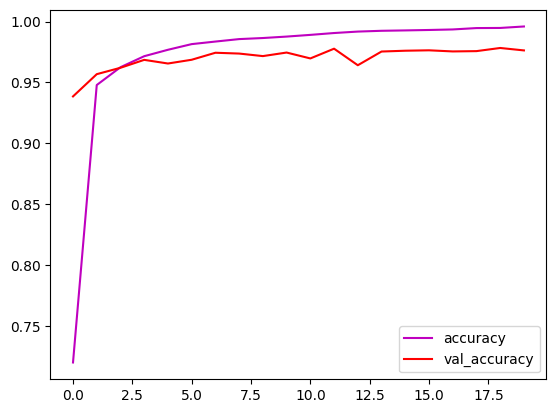

In [42]:
# Plot graphs
plt.plot(range(20), train_accs3, color='m', label='accuracy')
plt.plot(range(20),val_accs3, color='r', label='val_accuracy')
    
plt.legend()
plt.show()

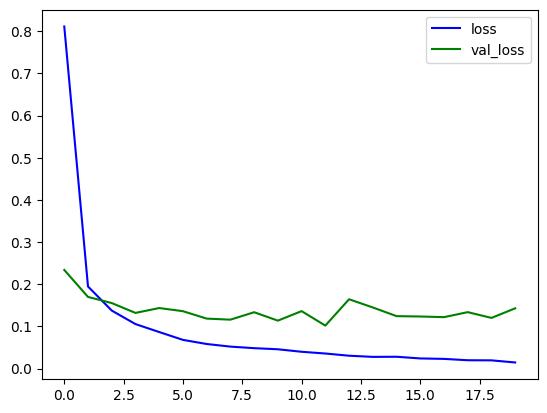

In [43]:
plt.plot(range(20), losses3, color='b', label='loss')
plt.plot(range(20), val_losses3, color='g', label='val_loss')

plt.legend()
plt.show()

In [44]:
# Print test loss and accuracy
test(model_deep)

Test Loss: 0.1425408494375477
Test Accuracy: %97.64


## Deep model 2 (complex one)

In [53]:
class Net4(nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
        self.flatten = nn.Flatten()
        self.hidden1l = nn.Linear(784, 256)
        self.hidden2l = nn.Linear(256, 128)
        self.hidden3l = nn.Linear(128, 64)
        self.hidden4l = nn.Linear(64, 32)
        
        self.hidden1r = nn.Linear(784, 256)
        self.hidden2r = nn.Linear(256, 128)
        self.hidden3r = nn.Linear(128, 32)
        
        self.concat = nn.Linear(64, 24)
        
        self.hidden2f = nn.Linear(24, 16)
        
        self.output = nn.Linear(16, 10)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        xl = self.relu(self.hidden1l(x))
        xl = self.relu(self.hidden2l(xl))
        xl = self.relu(self.hidden3l(xl))
        xl = self.relu(self.hidden4l(xl))
        
        xr = self.sigmoid(self.hidden1r(x))
        xr = self.sigmoid(self.hidden2r(xr))
        xr = self.sigmoid(self.hidden3r(xr))
        
        x = self.concat(torch.cat((xl, xr), dim=1))
        x = self.relu(x)
        x = self.relu(self.hidden2f(x))
        
        return x

In [54]:
# Create an instance of the model
model_deep_complex = Net4().to(device=device)
# Print model summary
print(model_deep_complex)

Net4(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (hidden1l): Linear(in_features=784, out_features=256, bias=True)
  (hidden2l): Linear(in_features=256, out_features=128, bias=True)
  (hidden3l): Linear(in_features=128, out_features=64, bias=True)
  (hidden4l): Linear(in_features=64, out_features=32, bias=True)
  (hidden1r): Linear(in_features=784, out_features=256, bias=True)
  (hidden2r): Linear(in_features=256, out_features=128, bias=True)
  (hidden3r): Linear(in_features=128, out_features=32, bias=True)
  (concat): Linear(in_features=64, out_features=24, bias=True)
  (hidden2f): Linear(in_features=24, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=10, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)


In [55]:
# Train the model
losses4, train_accs4, val_losses4, val_accs4 = train(25, model_deep_complex)

Epoch 1 - loss: 0.8887 - accuracy: 0.7198 - val_loss: 0.2692 - val_accuracy: 0.9352
Epoch 2 - loss: 0.1969 - accuracy: 0.9483 - val_loss: 0.1635 - val_accuracy: 0.9594
Epoch 3 - loss: 0.1337 - accuracy: 0.9650 - val_loss: 0.2720 - val_accuracy: 0.9410
Epoch 4 - loss: 0.0964 - accuracy: 0.9747 - val_loss: 0.1391 - val_accuracy: 0.9656
Epoch 5 - loss: 0.0798 - accuracy: 0.9787 - val_loss: 0.1356 - val_accuracy: 0.9672
Epoch 6 - loss: 0.0696 - accuracy: 0.9813 - val_loss: 0.1109 - val_accuracy: 0.9733
Epoch 7 - loss: 0.0573 - accuracy: 0.9841 - val_loss: 0.1311 - val_accuracy: 0.9684
Epoch 8 - loss: 0.0505 - accuracy: 0.9861 - val_loss: 0.1273 - val_accuracy: 0.9707
Epoch 9 - loss: 0.0438 - accuracy: 0.9876 - val_loss: 0.1121 - val_accuracy: 0.9755
Epoch 10 - loss: 0.0402 - accuracy: 0.9889 - val_loss: 0.1170 - val_accuracy: 0.9749
Epoch 11 - loss: 0.0323 - accuracy: 0.9909 - val_loss: 0.1254 - val_accuracy: 0.9751
Epoch 12 - loss: 0.0313 - accuracy: 0.9913 - val_loss: 0.1195 - val_accura

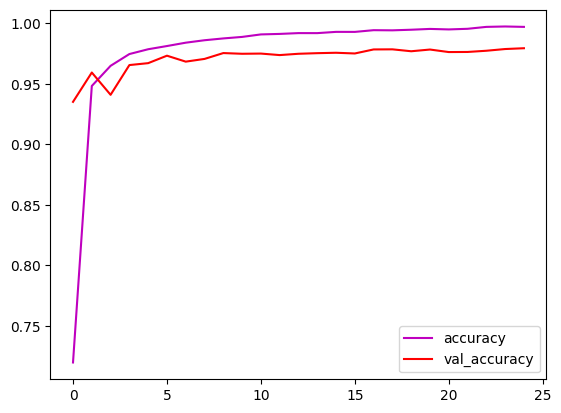

In [56]:
# Plot graphs
plt.plot(range(25), train_accs4, color='m', label='accuracy')
plt.plot(range(25),val_accs4, color='r', label='val_accuracy')
    
plt.legend()
plt.show()

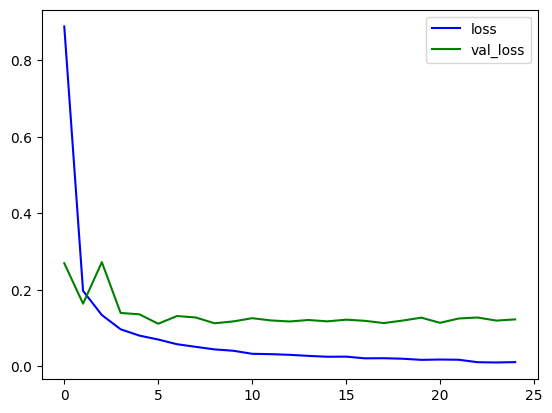

In [57]:
plt.plot(range(25), losses4, color='b', label='loss')
plt.plot(range(25), val_losses4, color='g', label='val_loss')

plt.legend()
plt.show()

In [58]:
# Print test loss and accuracy
test(model_deep)

Test Loss: 0.13163121507775857
Test Accuracy: %96.52
